In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
import torch
from torch.utils.data import DataLoader, Dataset
from tqdm import tqdm
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from nltk.tokenize import word_tokenize
import sklearn.metrics as metrics

In [12]:
# final data
group = pd.read_csv("group.csv")

## Data Analysis

In [23]:
# Count the number of 'y' in the cNEU column
count_y = (group['cNEU'] == 'y').sum()
print("Number of 'y' in cNEU column:", count_y)
# print("Percent of Neuroticism of total users:", (count_y/246)*100)

Number of 'y' in cNEU column: 1032


In [24]:
group = group.sample(frac=1).reset_index(drop=True)

In [35]:
# rename the column because textsplt is a weird name tbh
group = group.rename(columns={"textsplt": "text"})

## BERT Classification

In [36]:
# init empty results dict
results = {}

In [ ]:
from transformers import BertTokenizer, BertForSequenceClassification, AdamW, get_linear_schedule_with_warmup


# Split the data into training and validation sets
train_df, val_df = train_test_split(group, test_size=0.2, random_state=42)

# Define a custom dataset class
class CustomDataset(Dataset):
    def __init__(self, dataframe, tokenizer, max_length):
        self.dataframe = dataframe
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        text = self.dataframe.iloc[idx]['text']
        label = 1 if self.dataframe.iloc[idx]['cNEU'] == 'y' else 0
        encoding = self.tokenizer(text, truncation=True, padding='max_length', max_length=self.max_length, return_tensors='pt')
        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.tensor(label, dtype=torch.long)
        }

In [ ]:
# Load the BERT tokenizer and model
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=2)

# Create instances of the custom dataset
train_dataset = CustomDataset(train_df, tokenizer, max_length=128)
val_dataset = CustomDataset(val_df, tokenizer, max_length=128)

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=8, shuffle=False)

# Define the optimizer and learning rate scheduler
optimizer = AdamW(model.parameters(), lr=2e-5)
total_steps = len(train_loader) * 3  # Number of batches * number of epochs
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=total_steps)

# Training loop
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)
# put model in training mode
model.train()

In [ ]:
# init empty list for result
train_losses = []
val_accuracies = []
for epoch in range(4):  # Train for 3 epochs
    epoch_train_loss = 0.0
    for batch in tqdm(train_loader, desc=f'Epoch {epoch + 1}', leave=False):
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        optimizer.zero_grad()
        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        loss.backward()
        optimizer.step()
        scheduler.step()
        epoch_train_loss += loss.item()

    # Calculate validation metrics
    model.eval()
    val_preds = []
    val_labels = []
    with torch.no_grad():
        for batch in tqdm(val_loader, desc='Validation', leave=False):
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            outputs = model(input_ids, attention_mask=attention_mask)
            _, predicted = torch.max(outputs.logits, 1)
            val_preds.extend(predicted.tolist())
            val_labels.extend(labels.tolist())

    val_accuracy = accuracy_score(val_labels, val_preds)
    train_losses.append(epoch_train_loss / len(train_loader))
    val_accuracies.append(val_accuracy)

    print(f'Epoch {epoch + 1}: Train Loss: {epoch_train_loss / len(train_loader)}, Validation Accuracy: {val_accuracy}')
    # save model after every epoch
    torch.save(model.state_dict(),'epochBERT-{}.pth'.format(epoch))
    results['BERT'] = {
    'train_losses': train_losses,
    'val_accuracies': val_accuracies,
    }

# Plotting the training loss and validation metrics
sns.set_style('whitegrid')
plt.figure(figsize=(16, 6))

plt.subplot(1, 2, 1)
plt.plot(range(1, 5), train_losses, label='Train Loss', marker='o')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss over Epochs')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(range(1, 5), val_accuracies, label='Validation Accuracy', marker='o')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Validation Accuracy over Epochs')
plt.legend()


plt.tight_layout()
plt.show()


Text(0.5, 1.0, 'BERT')

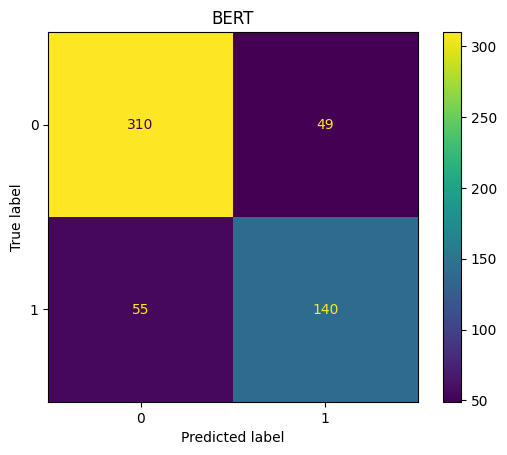

In [19]:
cmrf = metrics.confusion_matrix(val_labels, val_preds)
disprf = metrics.ConfusionMatrixDisplay(confusion_matrix=cmrf)
disprf.plot()
plt.title('BERT')

## XLNET Classification

In [ ]:
from transformers import XLNetTokenizer, XLNetForSequenceClassification, AdamW, get_linear_schedule_with_warmup

# Load the XLNet tokenizer and model
tokenizer = XLNetTokenizer.from_pretrained('xlnet-base-cased')
model = XLNetForSequenceClassification.from_pretrained('xlnet-base-cased', num_labels=2)

# Create instances of the custom dataset
train_dataset = CustomDataset(train_df, tokenizer, max_length=128)
val_dataset = CustomDataset(val_df, tokenizer, max_length=128)

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=8, shuffle=False)

# Define the optimizer and learning rate scheduler
optimizer = AdamW(model.parameters(), lr=2e-5)
total_steps = len(train_loader) * 4  # Number of batches * number of epochs
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=total_steps)

# Training loop
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)
# model to train mode
model.train()

In [ ]:
# init list for accuracy
train_losses = []
val_accuracies = []

for epoch in range(4):  # Train for 3 epochs
    epoch_train_loss = 0.0
    for batch in tqdm(train_loader, desc=f'Epoch {epoch + 1}', leave=False):
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        optimizer.zero_grad()
        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        loss.backward()
        optimizer.step()
        scheduler.step()
        epoch_train_loss += loss.item()

    # Calculate validation metrics
    model.eval()
    val_preds = []
    val_labels = []
    with torch.no_grad():
        for batch in tqdm(val_loader, desc='Validation', leave=False):
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            outputs = model(input_ids, attention_mask=attention_mask)
            _, predicted = torch.max(outputs.logits, 1)
            val_preds.extend(predicted.tolist())
            val_labels.extend(labels.tolist())

    val_accuracy = accuracy_score(val_labels, val_preds)
    train_losses.append(epoch_train_loss / len(train_loader))
    val_accuracies.append(val_accuracy)


    print(f'Epoch {epoch + 1}: Train Loss: {epoch_train_loss / len(train_loader)}, Validation Accuracy: {val_accuracy}')
    # save model after each epoch
    torch.save(model.state_dict(),'epochXLNET-{}.pth'.format(epoch))
    results['XLNet'] = {
    'train_losses': train_losses,
    'val_accuracies': val_accuracies
    }
# Plotting the training loss and validation metrics
sns.set_style('whitegrid')
plt.figure(figsize=(16, 6))

plt.subplot(1, 2, 1)
plt.plot(range(1, 5), train_losses, label='Train Loss', marker='o')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss over Epochs')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(range(1, 5), val_accuracies, label='Validation Accuracy', marker='o')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Validation Accuracy over Epochs')
plt.legend()

plt.tight_layout()
plt.show()

## BERT vs XLNET Comparison with Accuracy

In [ ]:
# Plotting the training loss and validation accuracy for both models
sns.set_style('whitegrid')
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
for model_name, result in results.items():
    plt.plot(range(1, 5), result['train_losses'], label=f'{model_name} Train Loss', marker='o')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss over Epochs')
plt.legend()

plt.subplot(1, 2, 2)
for model_name, result in results.items():
    plt.plot(range(1, 5, result['val_accuracies'], label=f'{model_name} Validation Accuracy', marker='o')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Validation Accuracy over Epochs')
plt.legend()

plt.tight_layout()
plt.show()
